<div style="border-radius:10px;
    border:#410159 solid;
    background-color:#fef1ff;
    font-size:110%;
    letter-spacing:0.5px;
    text-align: center">
<center><h1 style="padding: 25px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Home credit default risk</h1></center>
<center><h3 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">With Boosting models</h3></center>
<center><h4 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">(Modelisation)</h4></center>
</div>

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
To view EDA for this case, please refer to the notebook exploration 1&2 and preprocess</div>

#### After a careful study and consideration of all given files and the goal of the problem, we can notice that most files contain info about the previous loans, which means if we depend on these info, our model will struggle in generalization with new clients with no previous loans experience or info, so we will try to make the best use of only application info to make a model can generalize well.

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pandas import MultiIndex, Int64Index

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro
import pickle
from sklearn import metrics

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import pycaret
from pycaret.classification import *

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# ----------------------------------------------------
from sklearn.metrics import auc, roc_curve, roc_auc_score
from collections import Counter

from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, precision_score, average_precision_score
from sklearn.metrics import f1_score, accuracy_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_validate
import outils_model

import mlflow
import mlflow.sklearn

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
import time

C:\Users\Sofia\AppData\Local\Temp\ipykernel_18072\51650459.py:6: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Changement de l'affichage

pd.set_option('display.max_row',200)
pd.set_option('display.max_column',200)
pd.set_option('display.precision', 5)
pd.set_option('display.max_colwidth', None)

In [4]:
df_train = pd.read_csv(r"C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\data_model_train.csv")
df_train.shape

(307511, 71)

In [ ]:
df_test = pd.read_csv(r"C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\API\data_model_test.csv")
df_test.shape

In [5]:
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC',
       'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

y = df_train['TARGET']

### Modélisation simple

In [7]:
from sklearn.model_selection import train_test_split

# Découpage du jeu d'entraînement

X_train, X_test, y_train, y_test = train_test_split(df_train[col], y, test_size=0.2, random_state=100)

print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_test : {X_test.shape} - y_test : {y_test.shape}')

X_train : (246008, 69) - y_train : (246008,)
X_test : (61503, 69) - y_test : (61503,)


## Interprétabilité du modèle

In [116]:
# Chargement du meilleur modèle
fic_best_model = r'C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\modelisation\best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_bin=500,
               min_child_samples=600, n_estimators=250, num_leaves=10,
               objective='binary', random_state=100, reg_alpha=0.1,
               reg_lambda=0.1)

### Feature Importances : local

In [231]:
import shap

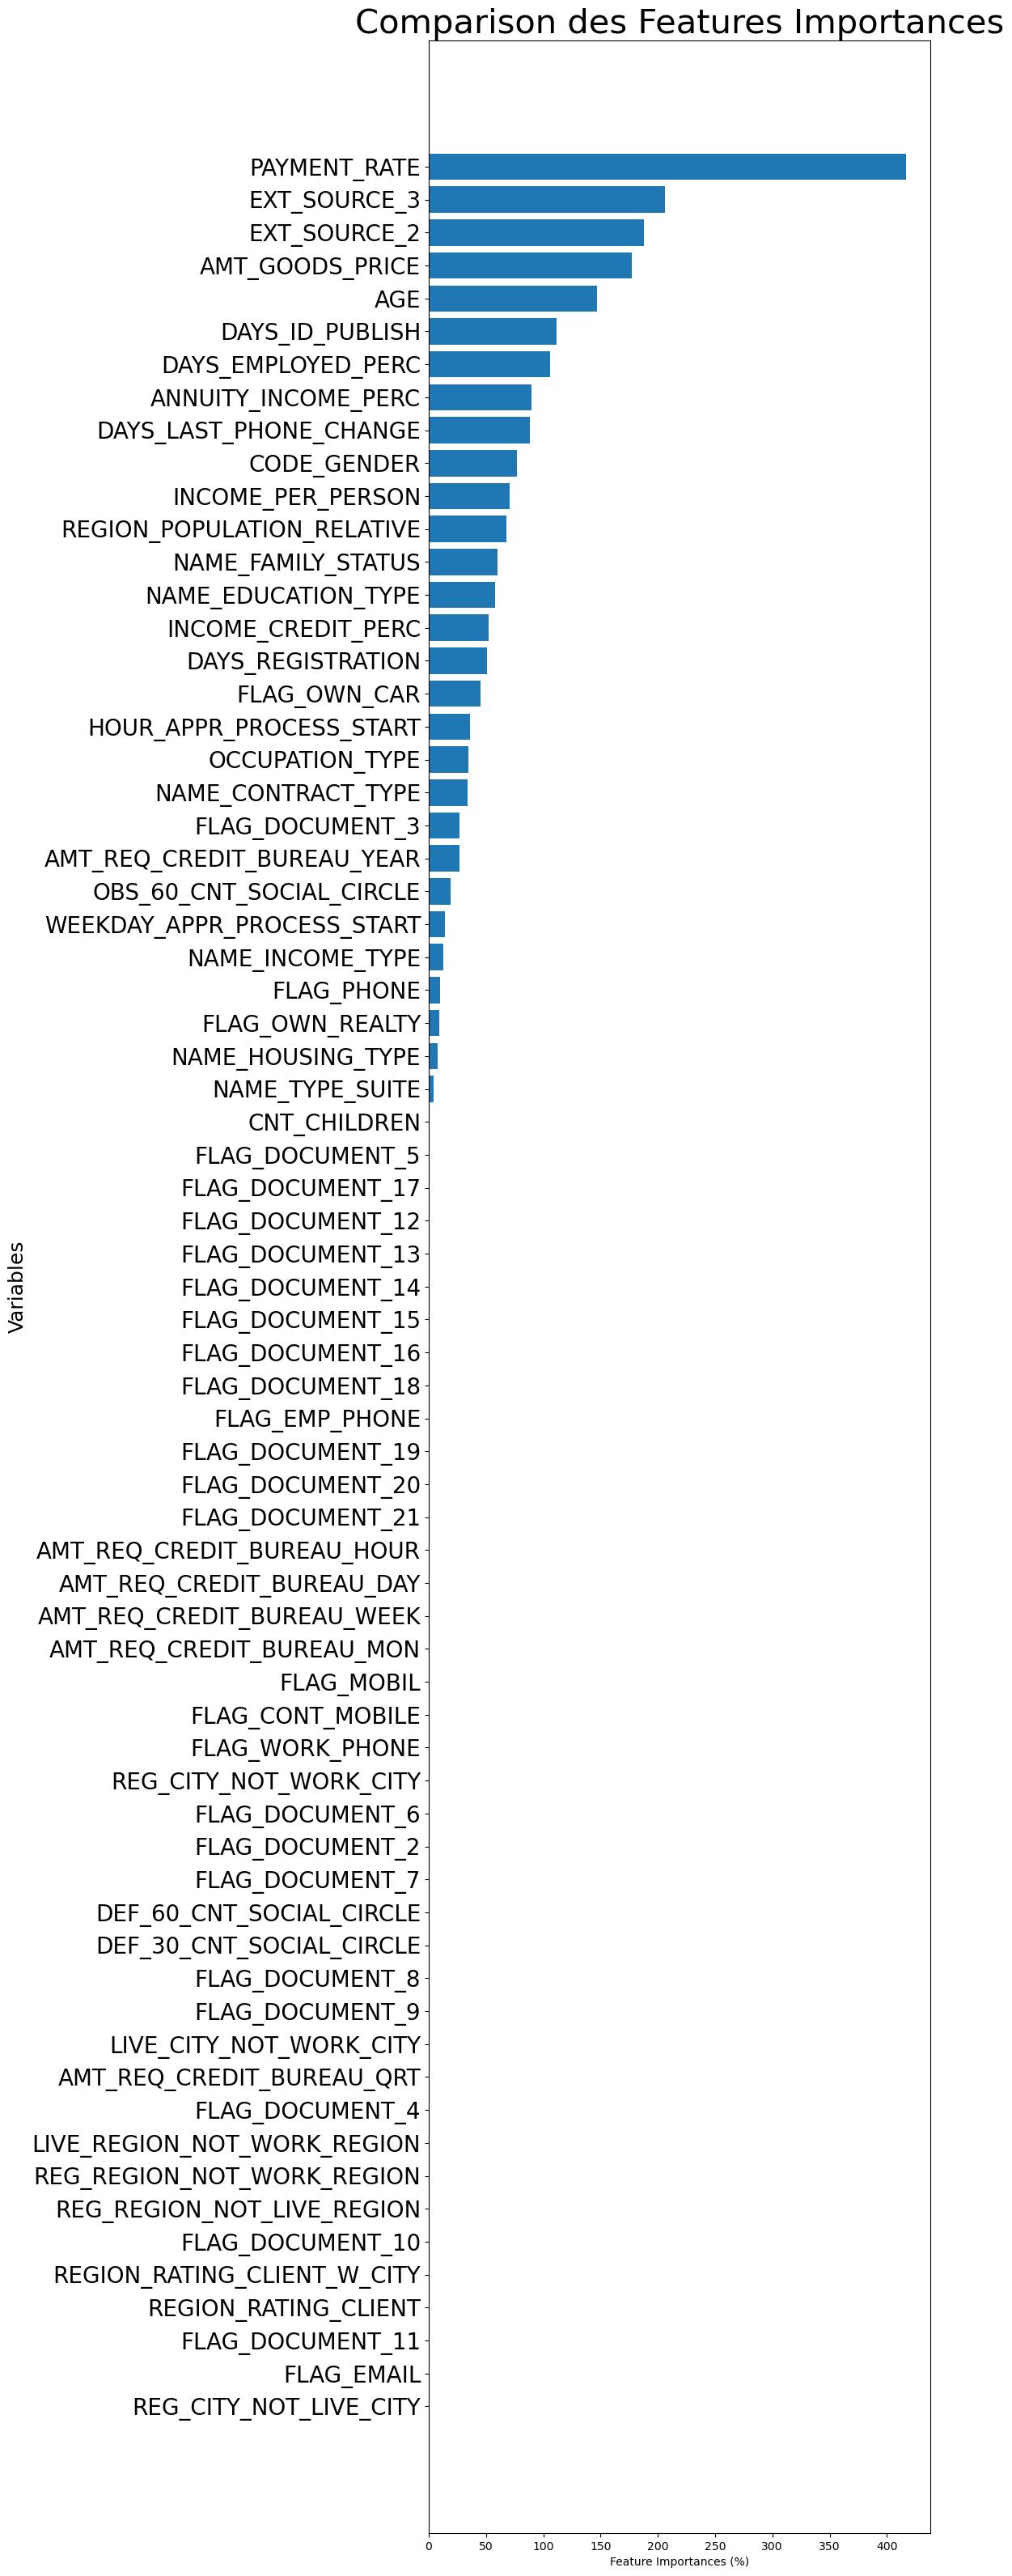

In [117]:
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
outils_model.plot_features_importance(feature_importance_values,
                                      feature_names, (8, 40))

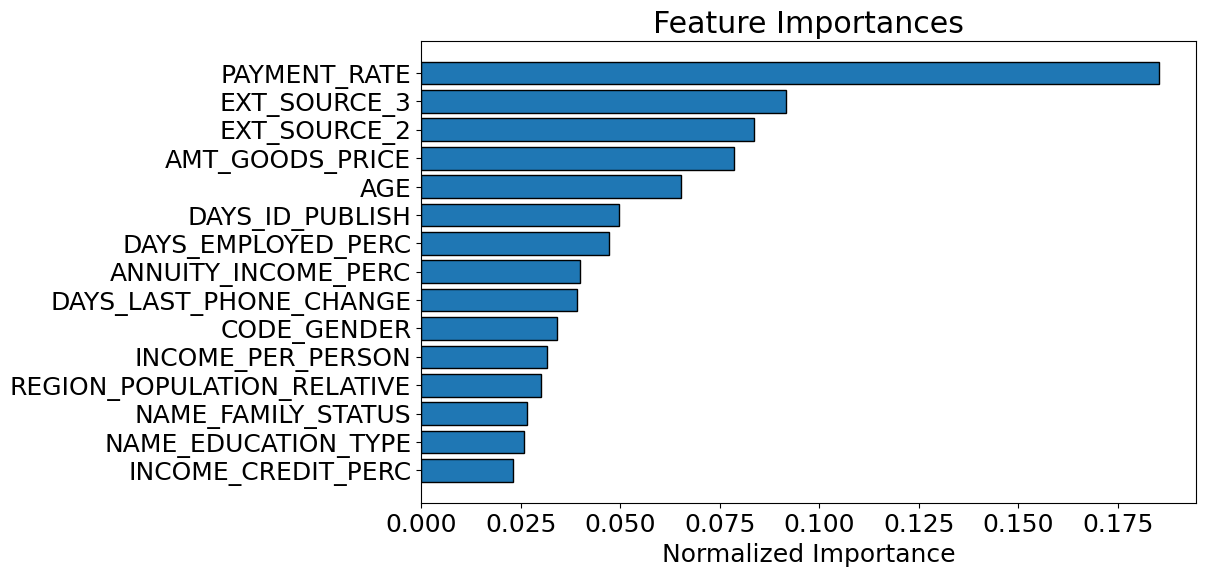

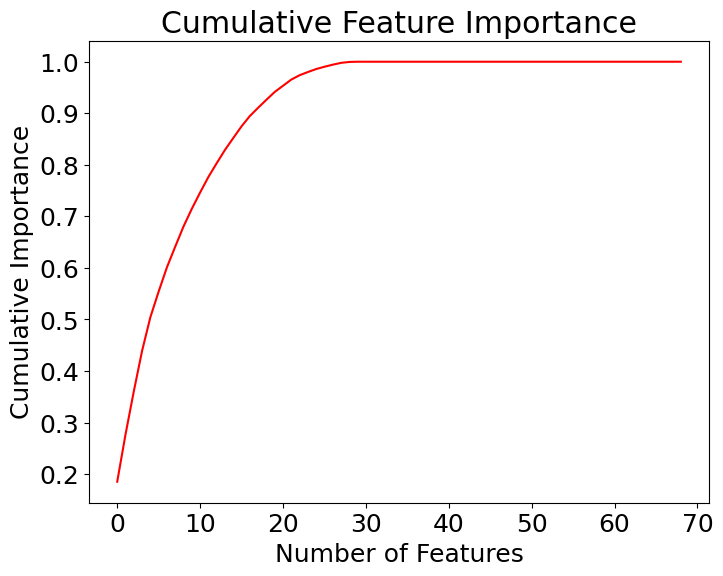

18 variables nécessaires pour 0.90 de cummulative imortance


In [118]:
# Impact des features importance cumulées
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': feature_importance_values})
# Show the feature importances for the new features
df_featimp = \
    outils_model.plot_cumultative_feature_importance(feature_importances)

In [119]:
df_featimp

,index,feature,importance,importance_normalized,cumulative_importance
0,9,PAYMENT_RATE,417,0.18533,0.18533
1,38,EXT_SOURCE_3,206,0.09156,0.27689
2,37,EXT_SOURCE_2,188,0.08356,0.36044
3,10,AMT_GOODS_PRICE,177,0.07867,0.43911
4,17,AGE,147,0.06533,0.50444
5,19,DAYS_ID_PUBLISH,112,0.04978,0.55422
6,5,DAYS_EMPLOYED_PERC,106,0.04711,0.60133
7,8,ANNUITY_INCOME_PERC,90,0.04000,0.64133
8,42,DAYS_LAST_PHONE_CHANGE,88,0.03911,0.68044
9,1,CODE_GENDER,77,0.03422,0.71467


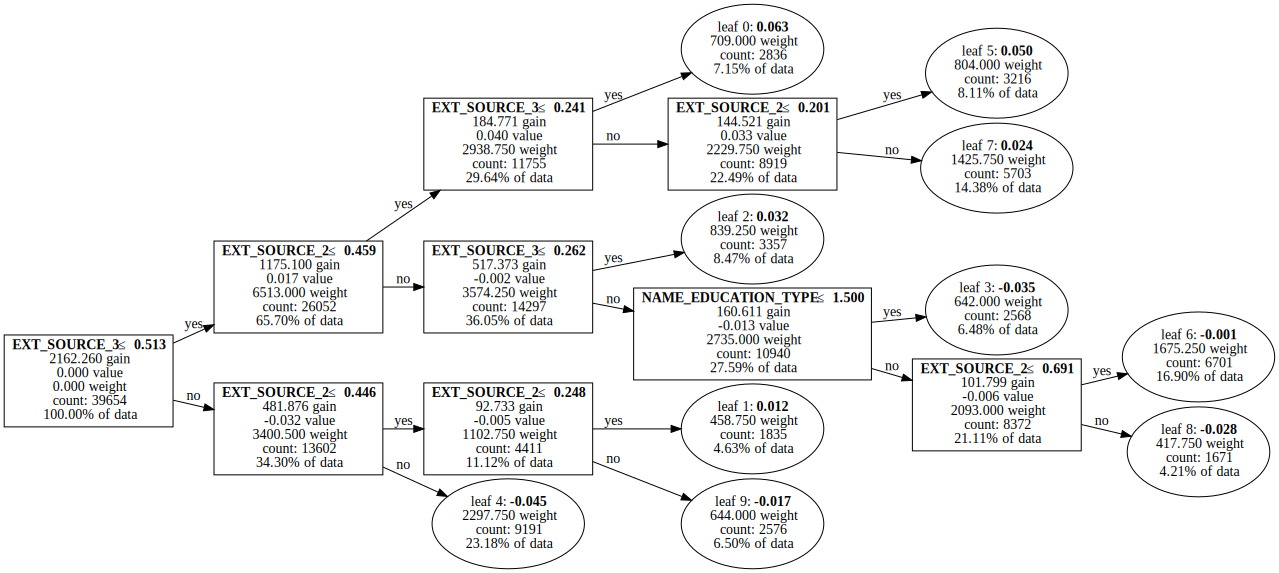

In [120]:
import lightgbm as lgb

lgb.create_tree_digraph(best_model, tree_index=0,
                        show_info=['split_gain', 'internal_value',
                                   'internal_count', 'internal_weight',
                                   'leaf_count', 'leaf_weight', 'data_percentage'])

### Shap : interprétabilité globale 

#### La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
#### La somme des effets de chaque variable expliquera la prédiction.

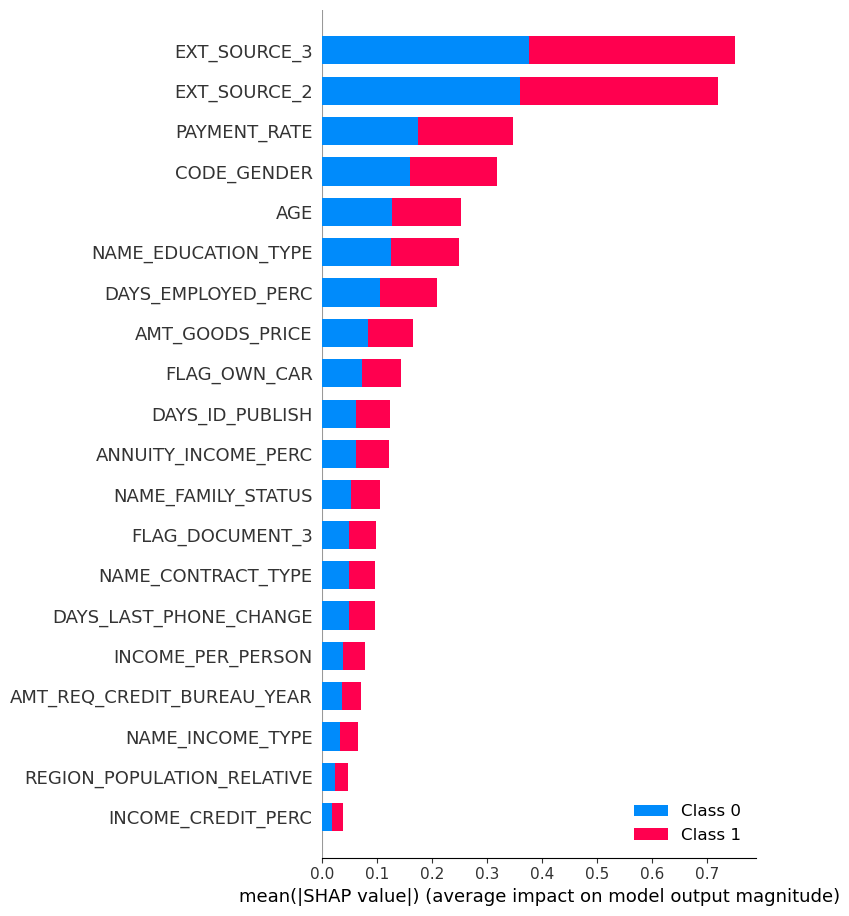

In [122]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
# Summary plot
shap.summary_plot(shap_values, X_test)

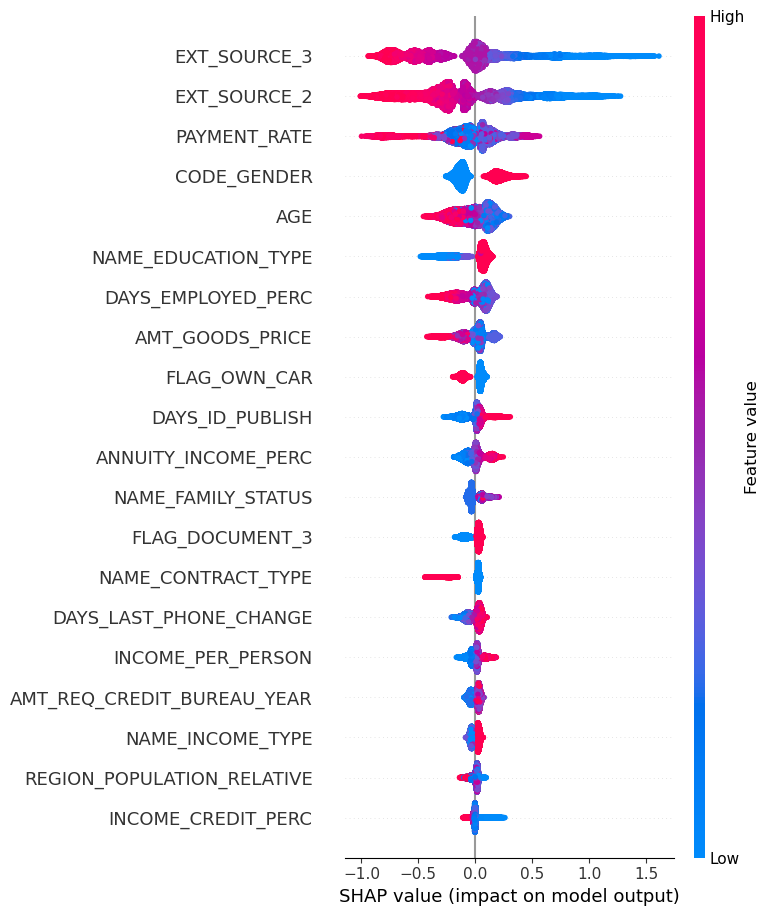

In [123]:
shap.summary_plot(shap_values[1], X_test, show=False)

In [125]:
explainer_bis = shap.Explainer(best_model, X_train)
shap_values_bis = explainer_bis(X_train, check_additivity=False)

100%|===================| 245861/246008 [24:47<00:00]        

#### Bar plot : l'importance globale des caractéristiques, où l'importance globale de chaque caractéristique est considérée comme la valeur absolue moyenne pour cette caractéristique sur tous les échantillons donnés.

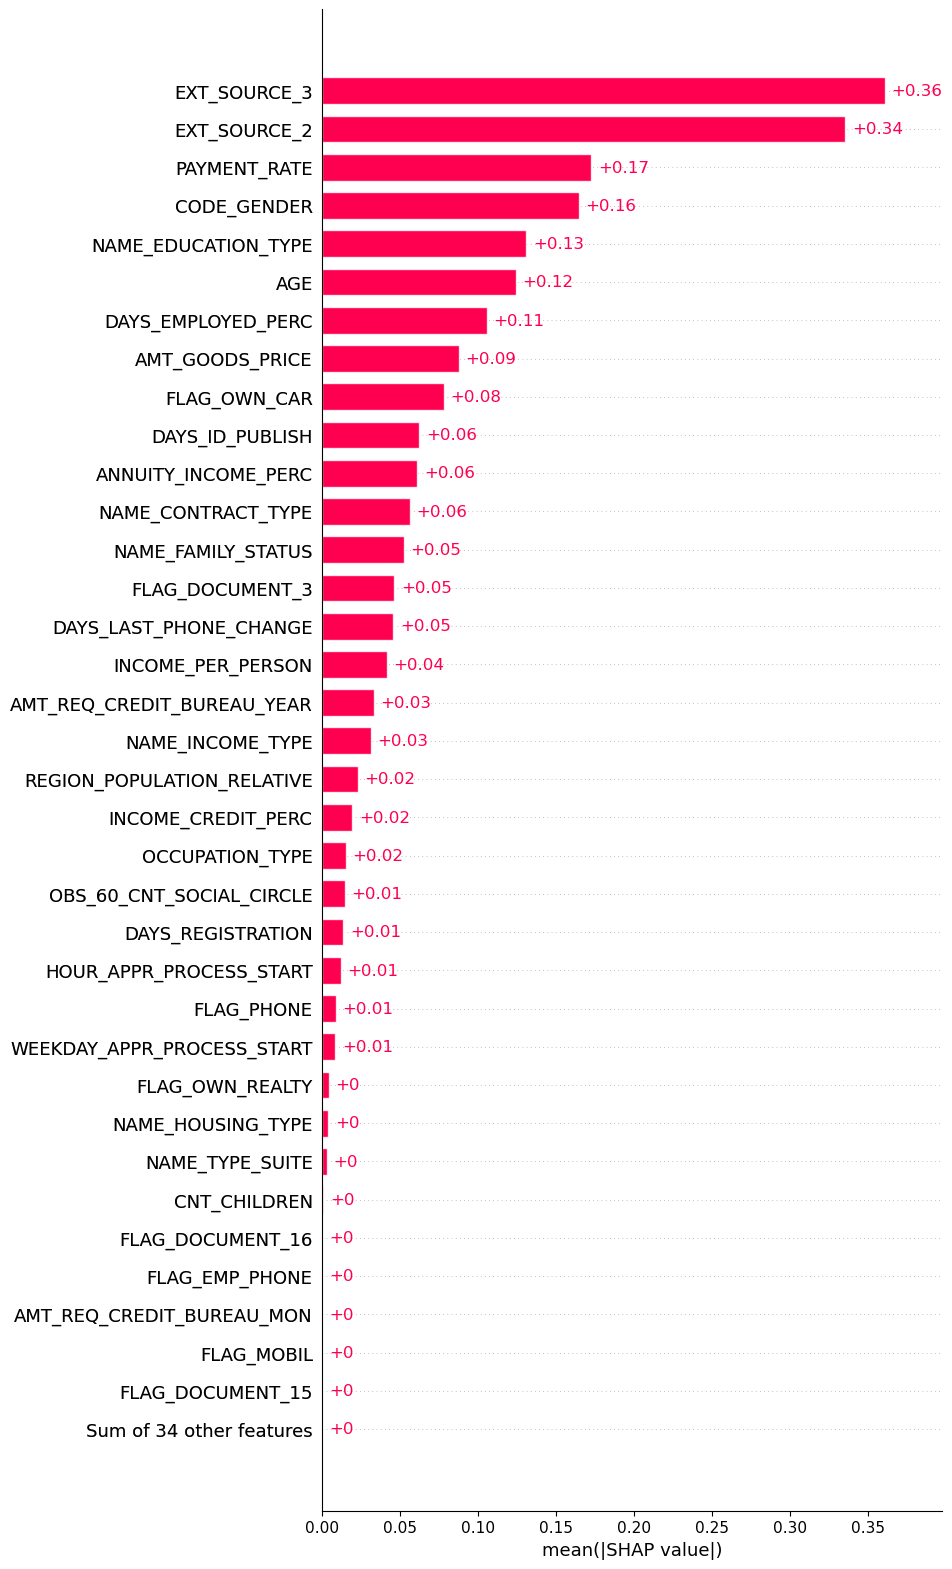

In [126]:
shap.plots.bar(shap_values_bis, max_display=36)

### Beeswarm :

#### ce graphique est conçu pour afficher un résumé dense en informations de la manière dont les principales caractéristiques d'un ensemble de données influencent la sortie du modèle.
#### Chaque instance de l'explication donnée est représentée par un seul point sur chaque graphique de caractéristiques. La position x du point est déterminée par la valeur SHAP (shap_values.value[instance,feature]) de cette caractéristique, et les points s'empilent le long de chaque ligne de caractéristique pour montrer la densité.
#### La couleur est utilisée pour afficher la valeur originale d'une caractéristique (shap_values.data[instance,feature]).

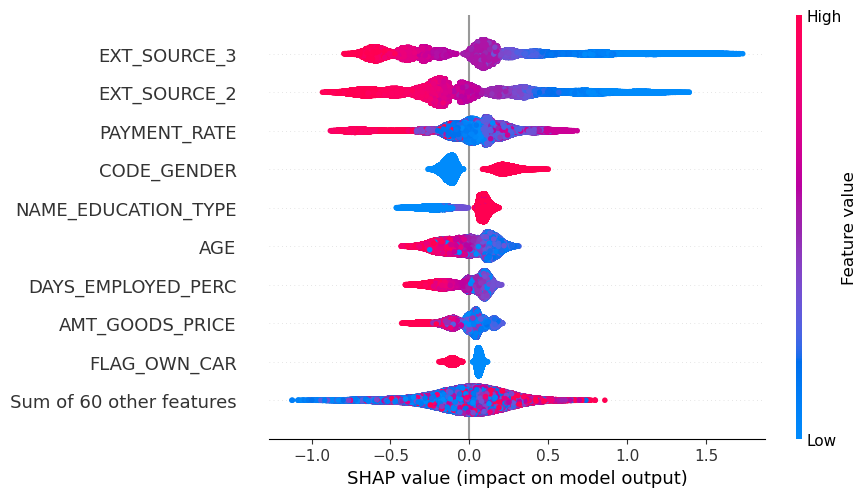

In [127]:
shap.plots.beeswarm(shap_values_bis)

In [154]:
explainer_test = shap.Explainer(best_model, df_test[col])

In [155]:
# Sauvegarde des résultats 
with open(r'C:\Users\Sofia\OneDrive\Documents\OpenClassrooms\Project_7\modelisation\lgbm_shap_explainer.pickle', 'wb') as df:
    pickle.dump(explainer_test, df, pickle.HIGHEST_PROTOCOL)